In [25]:
import utils
import numpy as np
import pandas as pd

import matplotlib.pylab as plt
import healpy as hp
import matplotlib
import matplotlib as mpl
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.lines import Line2D

from astropy.cosmology import Planck18  # Predefined cosmology model
import astropy.units as u

In [61]:
# General settings
import matplotlib as mpl
mpl.rc_file('/Users/ulyanadupletsa/Documents/PhDThesisPlots/matplotlibrc')

mpl.rc('xtick', labelsize = 21) 
mpl.rc('ytick', labelsize = 21)

In [27]:
user = 'ulyanadupletsa'

In [28]:
PATH_TO_CLASS_OUTPUT = '/Users/' + str(user) + '/Documents/Radio-Sirens/class_output/'

In [29]:
# settings
lmax = 192
nside = 64
npix = hp.nside2npix(nside)

zz = np.linspace(0.9, 1.1, 3)

In [30]:
Cls = utils.read_Cls_from_class(PATH_TO_CLASS_OUTPUT+'linear_cls_zmin%s_zmax%s.dat' %(zz[0], zz[-1]), lmax, len(zz), diag=False)

In [31]:
# generate HI maps for each redshift bin from CLASS Cls
np.random.seed(42)
maps = np.zeros((len(zz), npix), dtype=float) 

for i in range(len(zz)):
    maps[i, :] = hp.synfast(Cls['z_bin' + str(i+1)], nside, lmax=lmax)

In [32]:
prob_map = np.zeros((len(zz), npix), dtype=float) 
for i in range(len(zz)):
    prob_map[i, :] = maps[i, :] - np.min(maps[i, :])
    prob_map[i, :] = prob_map[i, :]/np.sum(prob_map[i, :])

In [33]:
n_gws = [1000, 10000, 100000, 1000000, 10000000]
gws_lbs = ['1e3', '1e4', '1e5', '1e6', '1e7']

### GW maps
Each pixel has a probability to host a GW event proportional to the density of hydrogen in that pixel. Therefore, we draw from the numbered pixel vector, a number of indeces corresponding to the number of the desired GW events with probability as explained above. This gives us the index of the pixels that host GW events.



In [34]:
maps_gws = np.zeros((len(n_gws), len(zz), npix))
np.random.seed(42)
for num in n_gws:
    pix_indexes = np.zeros((len(zz), num), dtype=float) 
    for i in range(len(zz)): 
        pix_indexes[i, :] = np.random.choice(np.arange(npix), num, p=prob_map[i, :])
        for j in pix_indexes[i, :]:
            maps_gws[n_gws.index(num), i, int(j)] += 1


        
    gws_per_pixel = num / npix
    for i in range(len(zz)):
        maps_gws[n_gws.index(num), i, :] = (maps_gws[n_gws.index(num), i, :] - gws_per_pixel)/gws_per_pixel
        

In [62]:
color1 = '#2f4f4f'
color2 = '#eba75f'
mycmap = LinearSegmentedColormap.from_list("my_cmap", [color1, color2])
colors = [mycmap(i) for i in np.linspace(0, 1, len(n_gws))]
myfontsize=26

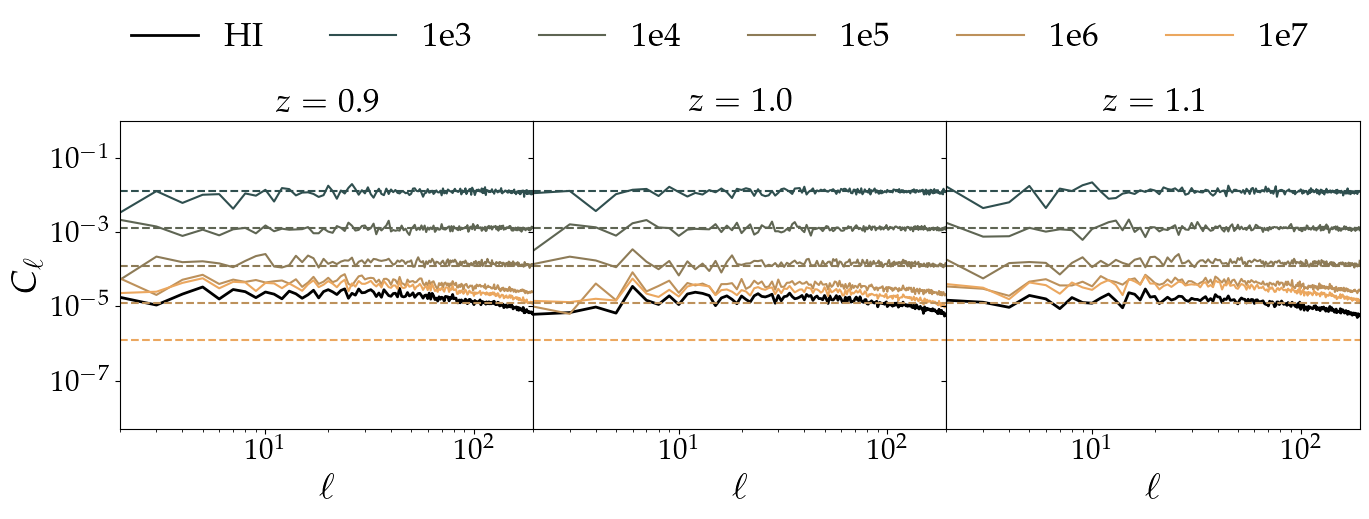

In [69]:
# compare Cls from gws and Cls from class
fig, axs =  plt.subplots(1, 3, figsize=(16, 4), sharey=True)

alpha_shade = np.linspace(0.25, 1, len(n_gws))
for i in range(len(zz)):
    axs[i].loglog(hp.anafast(maps[i, :], lmax=lmax), linestyle='-', color='black', linewidth=2.)
    #axs[i].loglog(Cls['z_bin' + str(i+1)], linestyle='--', color='black')
    for num in n_gws:
        Cl_observed = hp.anafast(maps_gws[n_gws.index(num), i, :], lmax=lmax)
        axs[i].loglog(Cl_observed, color=colors[n_gws.index(num)], linestyle='solid')
        axs[i].set_xlim(2, 192)
        axs[i].set_ylim(0.5*10**(-8), 1)
        axs[i].set_xlabel(r'$\ell$', fontsize=myfontsize)
        axs[i].set_title('$z= %s$'%str(zz[i]), fontsize=myfontsize-2)

axs[0].set_ylabel(r'$C_{\ell}$', fontsize=myfontsize)
fig.legend(['HI']+gws_lbs, loc='upper center', bbox_to_anchor=(0.5, 1.2), 
           ncol=2+len(n_gws), frameon=False, fontsize=myfontsize-2)
for i in range(len(zz)):
    for num in n_gws:
        f_sky = np.sum(prob_map[i, :] > 0) / npix #it's almost 1
        Cl_noise = 4 * np.pi / (f_sky * num)        
        axs[i].axhline(Cl_noise, color=colors[n_gws.index(num)], linestyle='dashed')
plt.subplots_adjust(wspace=0, 
                    hspace=0.35)
plt.savefig('plots/Cls_from_gws.pdf', bbox_inches='tight')
plt.show()

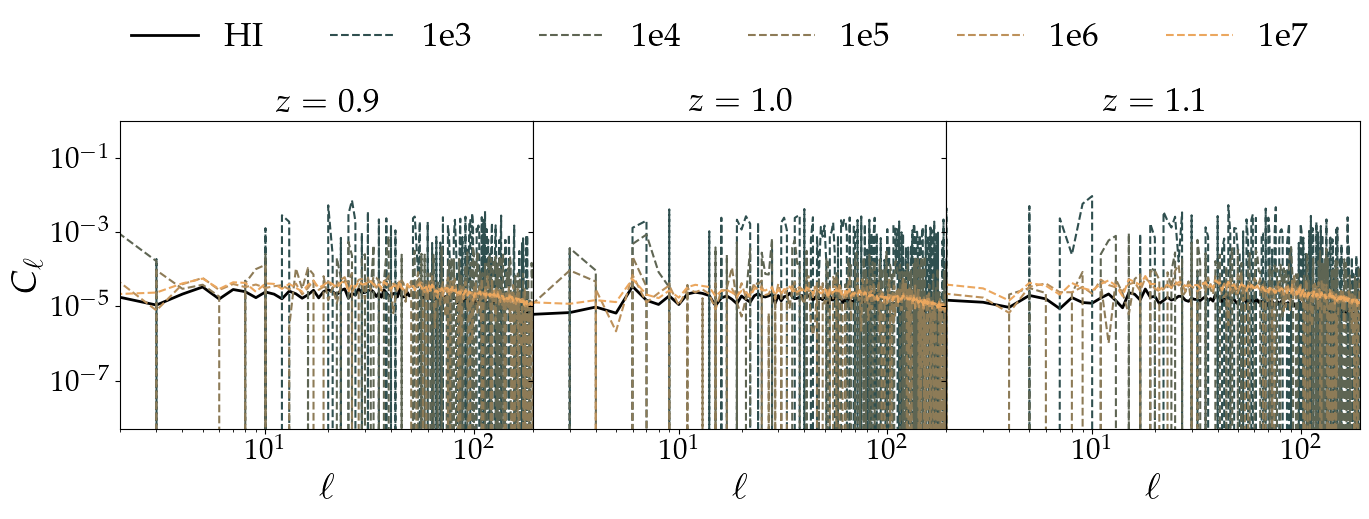

In [70]:
# compare Cls from gws and Cls from class
fig, axs =  plt.subplots(1, 3, figsize=(16, 4), sharey=True)

alpha_shade = np.linspace(0.25, 1, len(n_gws))
for i in range(len(zz)):
    axs[i].loglog(hp.anafast(maps[i, :], lmax=lmax), linestyle='-', color='black', linewidth=2.)
    #axs[i].loglog(Cls['z_bin' + str(i+1)], linestyle='--', color='black')
    for num in n_gws:
        f_sky = np.sum(prob_map[i, :] > 0) / npix #it's almost 1
        Cl_observed = hp.anafast(maps_gws[n_gws.index(num), i, :], lmax=lmax)
        Cl_noise = 4 * np.pi / (f_sky * num)
        Cl_map = Cl_observed - Cl_noise
        #axs[i].axhline(Cl_noise, color=colors[n_gws.index(num)], linestyle='--')
        axs[i].loglog(Cl_map, color=colors[n_gws.index(num)], linestyle='dashed')
        axs[i].set_xlim(2, 192)
        axs[i].set_ylim(0.5*10**(-8), 1)
        axs[i].set_xlabel(r'$\ell$', fontsize=myfontsize)
        axs[i].set_title('$z=%s$'%str(zz[i]), fontsize=myfontsize-2)

axs[0].set_ylabel(r'$C_{\ell}$', fontsize=myfontsize)
fig.legend(['HI']+gws_lbs, loc='upper center', bbox_to_anchor=(0.5, 1.2), 
           ncol=2+len(n_gws), frameon=False, fontsize=myfontsize-2)
plt.subplots_adjust(wspace=0, 
                    hspace=0.35)
#plt.savefig('Cls_from_gws.pdf')
plt.show()

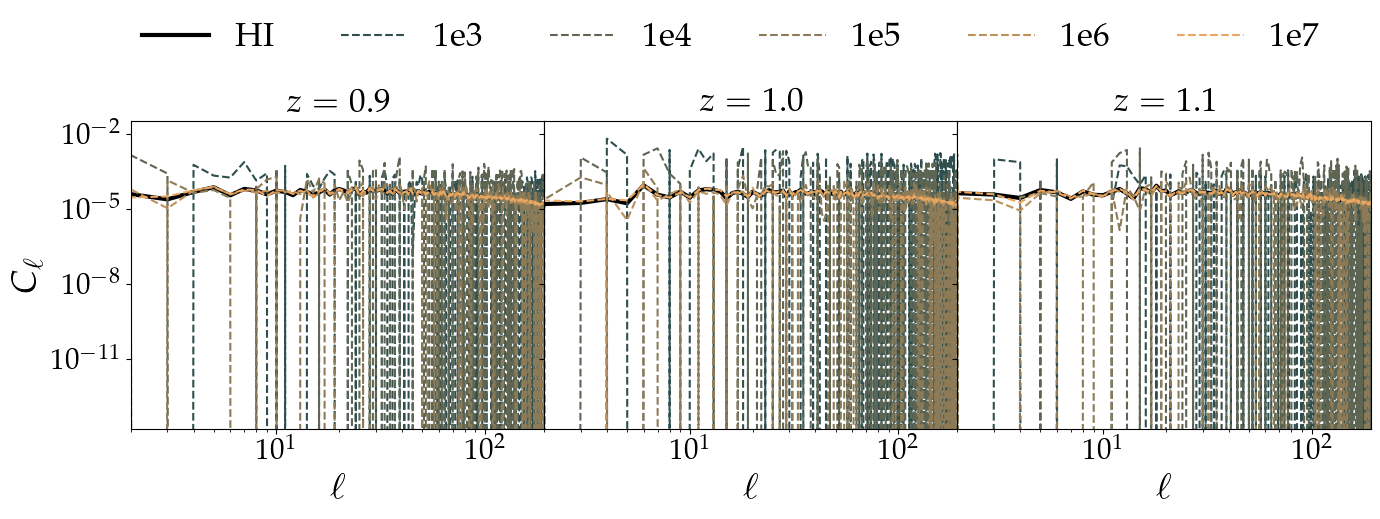

In [71]:
# compare Cls from gws and Cls from class
initial_idx = 0
ells = np.linspace(0, lmax, lmax+1)
fig, axs =  plt.subplots(1, 3, figsize=(16, 4), sharey=True)

alpha_shade = np.linspace(0.25, 1, len(n_gws))
for i in range(len(zz)):
    axs[i].loglog(hp.anafast(maps[i, :], lmax=lmax)/(np.sum((2*ells+1)*hp.anafast(maps[i, :], lmax=lmax))), 
                  label='HI', linestyle='-', color='black', linewidth=3.)
    #axs[i].loglog(Cls['z_bin' + str(i+1)]/(np.sum((2*ells + 1) *Cls['z_bin' + str(i+1)])), label='HI-CLASS', linestyle='--', color='black')
    for num in n_gws[initial_idx:]:
        f_sky = np.sum(prob_map[i, :] > 0) / npix #it's almost 1
        Cl_observed = hp.anafast(maps_gws[n_gws.index(num), i, :], lmax=lmax)
        Cl_noise = 4 * np.pi / (f_sky * num)
        Cl_map = Cl_observed - Cl_noise
        axs[i].loglog(Cl_map/(np.sum((2*ells+1)*Cl_map)), label='GWs = '+str(num), color=colors[n_gws.index(num)], linestyle='dashed')
        axs[i].set_xlim(2, 192)
        #axs[i].set_ylim(1e-6, 1e-3)
        axs[i].set_xlabel(r'$\ell$', fontsize=myfontsize)
        axs[i].set_title('$z=%s$'%str(zz[i]), fontsize=myfontsize-2)

axs[0].set_ylabel(r'$C_{\ell}$', fontsize=myfontsize)
fig.legend(['HI']+gws_lbs[initial_idx :], loc='upper center', bbox_to_anchor=(0.5, 1.2), 
           ncol=2+len(n_gws), frameon=False, fontsize=myfontsize-2)
plt.subplots_adjust(wspace=0, 
                    hspace=0.35)
plt.savefig('plots/Cls_from_gws_denoised.pdf', bbox_inches='tight')
plt.show()